# Manually load and inspect Ylm_depict data

In [1]:
# Low-level import 
from numpy import array,loadtxt,linspace,zeros,exp,ones,unwrap,angle,pi

# Setup ipython environment
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Import useful things from kerr
from kerr.formula.ksm2_cw import CW as cwfit
from kerr.formula.ksm2_sc import SC as scfit
from kerr.pttools import leaver_workfunction as lvrwork
from kerr import leaver,rgb
from kerr.models import mmrdns 

#
from nrutils import scsearch,gwylm,gwf

# Setup plotting backend
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 0.8
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.labelsize'] = 20
from matplotlib.pyplot import *

In [33]:
T0 = 10
ll,mm = 4,3
q = 4
data_file_string = '/Users/book/GARREG/Spectroscopy/Ylm_Depictions/NonPrecessing/MULTI_DATA_6/T0_%i_nmax2_Mmin97ll_Mmin_r75_qref1.50__p1_17-Mar-2014gnx_/Data_Sets/HRq-series/D9_q%1.1f_a0.0_m160/DEPICTION_INFO::NODD_INPUT_ll%i_mm%i_r75.asc'%(T0,q,ll,mm)
data = loadtxt(data_file_string)

In [34]:
# Collect raw fit data for later convenience
rfdata = {}
for k,row in enumerate(data):
    #
    ll,mm,q,m1,m2,x1,x2,jf,Mf,qid,rew,imw,rewfit,imwfit,reA,imA,reAmean,imAmean,minA,maxA,T1,dT,match,rmse,reB,imB,reBmean,imBmean,minB,maxB = row
    ll,mm = int(ll),int(mm)
    A = reA+1j*imA
    cw = rew + 1j*imw
    try:
        l,m,n,p = mmrdns.calc_z(qid)
    except:
        l,m,n,p,l2,m2,n2,p2 = mmrdns.calc_z(qid)
    rfdata[(l,m,n,p)] = {}
    rfdata[(l,m,n,p)]['ll'],rfdata[(l,m,n,p)]['mm'],rfdata[(l,m,n,p)]['A'],rfdata[(l,m,n,p)]['cw'] = ll,mm,A,cw

In [35]:
print angle( rfdata[(mm,mm,0,1)]['A'] * rfdata[(ll,mm,0,1)]['A'].conj() )
print angle( mmrdns.Afit(mm,mm,0,mmrdns.q2eta(q))  * mmrdns.Afit(ll,mm,0,mmrdns.q2eta(q)).conj() )

2.53376085128
-2.5077131516


(scsearch)>> Found keyword (='hrq') keyword.
(scsearch)>> Found nonspinning (=True) keyword.
(scsearch)>> Found q (=4.0) keyword.
(scsearch)>> Found verbose (=True) keyword.
(scsearch)>> List of keywords or string keyword found: ALL scentry objects matching will be passed. To pass ANY entries matching the keywords, input the keywords using an iterable of not of type list.
## Found 1 possibly degenerate simulations:
[0001][bradwr] HRq-series: ns-q4.00	(D9_q4.0_a0.0_m160)

(gwylm)>> Found dt (=0.5) keyword.
(gwylm)>> Found lm (=([4, 3], [2, 2])) keyword.
(gwylm)>> Found scentry_obj (=<nrutils.core.nrsc.scentry instance at 0x10cd47b00>) keyword.
(gwylm)>> Found verbose (=True) keyword.
(validate!)>> Multiple catalog directories found. We will scan through the related list, and then store first the catalog_dir that the OS can find.
(validate!)>> Selecting "/Volumes/athena/bradwr/"
(gwylm)>> The (extraction_parameter,level) is (75.0,None), which differs from the config values of (75,0). You

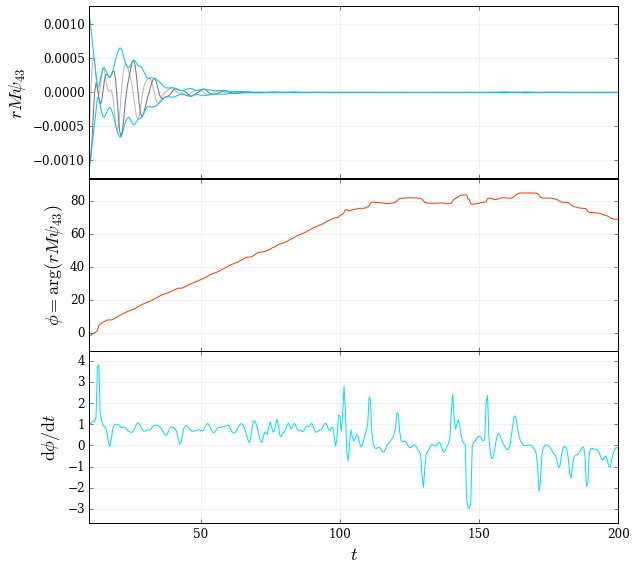

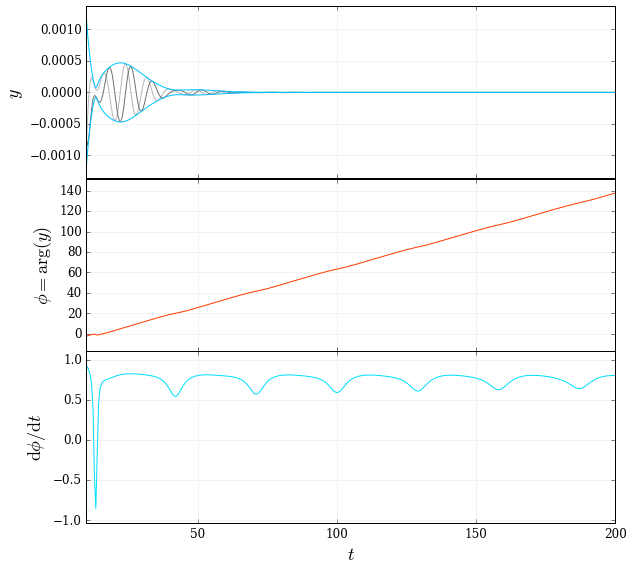

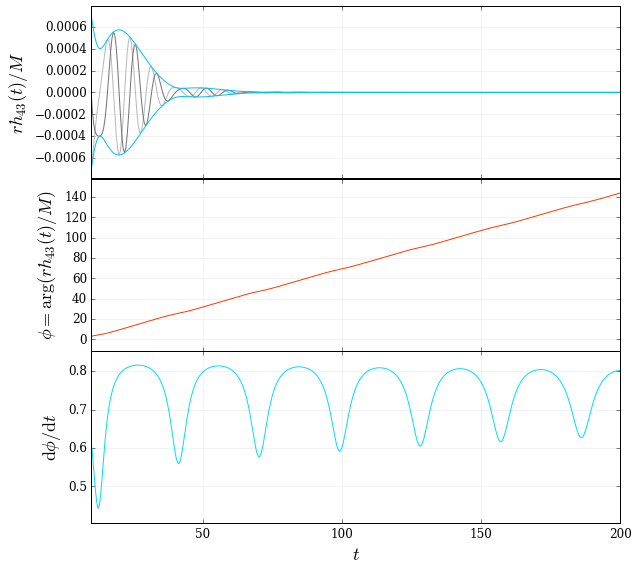

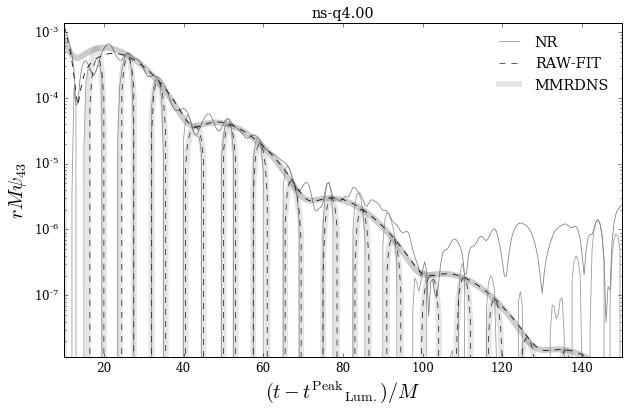

In [37]:


#
def rawfit(t):
    y = zeros( t.shape, dtype=complex )
    for k,row in enumerate(data):
        #
        ll,mm,q,m1,m2,x1,x2,jf,Mf,qid,rew,imw,rewfit,imwfit,reA,imA,reAmean,imAmean,minA,maxA,T1,dT,match,rmse,reB,imB,reBmean,imBmean,minB,maxB = row
        ll,mm = int(ll),int(mm)
        A = reA+1j*imA
        cw = rew + 1j*imw
        try:
            l,m,n,p = mmrdns.calc_z(qid)
        except:
            l,m,n,p,l2,m2,n2,p2 = mmrdns.calc_z(qid)
        # NOTE that the amplitudes are for Psi4 here
        if True: # (l,m,n,p) in [ (2,2,0,1) ,(2,2,1,1) ]  :
            y += A*exp( 1j*cw*(t-T0) ) * ( (-1)**ll )
            
    #
    a = gwf( array( [t,y.real,-y.imag] ).T )
    
    #
    return a,q

_,q = rawfit( linspace(T0,50) )

#
A = scsearch( keyword='hrq', q=q, nonspinning=True,verbose=True )[0]

#
imrnr = gwylm( A, lm=([ll,mm],[2,2]), verbose=True, dt=0.5 )
nr = imrnr.ringdown(T0=T0,T1=200,use_peak_strain=False)

y,_ = rawfit( nr.lm[(ll,mm)]['psi4'].t )

#
eta = mmrdns.q2eta(q)
h = mmrdns.meval_spherical_mode(ll,mm,eta,kind='psi4',gwfout=True)(nr.ylm[0].t)

h.align(nr.lm[(ll,mm)]['psi4'],method='average-phase',mask=nr.ylm[0].t<60)
y.align(nr.lm[(ll,mm)]['psi4'],method='average-phase',mask=nr.ylm[0].t<60)

nr.lm[(ll,mm)]['psi4'].plot()
y.plot()
h.plot()

fig = figure( figsize=2*array([5,3]) )
gca().set_yscale("log", nonposy='clip')

plot( nr.ylm[0].t, nr.lm[(ll,mm)]['psi4'].amp, color=0.5*ones((3,)), label=None )
plot( nr.ylm[0].t, y.amp, '--k', label=None )
plot( nr.ylm[0].t, h.amp, 'k', alpha=0.2, linewidth=6, label=None )

# plot( nr.ylm[0].t, nr.lm[(ll,mm)]['psi4'].plus, color=0.5*ones((3,)), label='NR' )
# plot( nr.ylm[0].t, y.plus, '--k', label='RAW-FIT' )
# plot( nr.ylm[0].t, h.plus, 'k', alpha=0.2, linewidth=6,label='MMRDNS' )

plot( nr.ylm[0].t, nr.lm[(ll,mm)]['psi4'].cross, color=0.5*ones((3,)), label='NR', alpha=0.8 )
plot( nr.ylm[0].t, y.cross, '--k', label='RAW-FIT', alpha=0.8 )
plot( nr.ylm[0].t, h.cross, 'k', alpha=0.1, linewidth=6, label='MMRDNS' )

ylim( [max(nr.lm[(ll,mm)]['psi4'].amp)*1e-5,1.2*max(nr.lm[(ll,mm)]['psi4'].amp)] )
xlim( [T0,150] )

xlabel(r'$(t-{t^{\mathrm{Peak}}}_{\mathrm{Lum.}})/M$')
ylabel(r'${rM}\psi_{%i%i}$'%(ll,mm))

legend(frameon=False)
title( nr.label )

savefig('mmrdns_psi4_comparison_%s_ll%imm%i.pdf'%(nr.label.replace('-','_'),ll,mm))

# gca().set_yscale("log", nonposy='clip')

### NOTES



In [ ]:
nr.simdir
